In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!pip install top2vec
!pip install top2vec[sentence_encoders]
!pip install top2vec[sentence_transformers]
!pip install top2vec[indexing]
!pip install octis
!pip install pyvis

In [ ]:
import pandas as pd
import spacy
import numpy as np
import re
from tqdm.auto import tqdm
import umap
import matplotlib.pyplot as plt
from top2vec import Top2Vec
from octis.evaluation_metrics.diversity_metrics import TopicDiversity
from octis.evaluation_metrics.coherence_metrics import Coherence
from octis.dataset.dataset import Dataset
import networkx as nx
from pyvis.network import Network
from IPython.core.pylabtools import figsize

In [ ]:
df = pd.read_csv('/content/gdrive/MyDrive/thesis_datasets/emotion_regulation/emotion_regulation.csv')

In [ ]:
def removing_na(df, COLUMN):
  # remove the rows with NA
  df = df.loc[(df[COLUMN].isna() == False)]
  return df

In [ ]:
def preprocessing(df, COLUMN):
  # pre processing
  nlp = spacy.load("en_core_web_sm")
  texts = df[COLUMN]

  processed_texts = [text for text in tqdm(nlp.pipe(texts, 
                                              disable=["ner",
                                                       "parser"]),
                                          total=len(texts))]
  # lemmatizing, removing stop words and panctuation, lowercasing and taking nouns and adjectives
  lemmatized_texts = [[token.lemma_.lower() for token in doc if 
                    not token.is_punct and not token.is_stop and (token.pos_ == 'NOUN' or token.pos_ == 'ADJ')] for doc in processed_texts]
  # remove numbers
  lemmatized_texts = [[re.sub(r'^[0-9]+|^.$', '', word) for word in text] for text in lemmatized_texts]
  # remove empty values
  lemmatized_texts = [[token for token in text if token != ''] for text in lemmatized_texts]
  return lemmatized_texts

In [ ]:
df_keywords  = removing_na(df, COLUMN = 'keywords')
lemmatized_keywords = preprocessing(df_keywords, COLUMN = 'keywords')

  0%|          | 0/5031 [00:00<?, ?it/s]

In [ ]:
df_abstracts  = removing_na(df, COLUMN = 'abstract')
lemmatized_abstracts = preprocessing(df_abstracts, COLUMN = 'abstract')

  0%|          | 0/6098 [00:00<?, ?it/s]

# KEYWORDS

In [ ]:
list_keywords = df_keywords['keywords'].to_list()

In [ ]:
model_keywords = Top2Vec(list_keywords, embedding_model='universal-sentence-encoder',ngram_vocab= True, speed="deep-learn", workers=8)

2022-06-20 12:54:13,814 - top2vec - INFO - Pre-processing documents for training
2022-06-20 12:54:14,246 - top2vec - INFO - Downloading universal-sentence-encoder model
2022-06-20 12:54:33,938 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding
2022-06-20 12:54:36,102 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents
/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)
2022-06-20 12:55:17,806 - top2vec - INFO - Finding dense areas of documents
INFO:top2vec:Finding dense areas of documents
2022-06-20 12:55:18,078 - top2vec - INFO - Finding topics
INFO:top2vec:Finding topics


In [ ]:
model_keywords.get_num_topics()

40

In [ ]:
topic_words_key, word_scores_key, topic_nums_key = model_keywords.get_topics()


In [ ]:
keywords_embeddings =  model_keywords.document_vectors

In [ ]:
# Prepare data
umap_data = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine').fit_transform(keywords_embeddings)
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = pd.Series(model_keywords.doc_top)

In [ ]:
result['labels'].nunique()

40

In [ ]:
topics_labels_keywords_df = pd.DataFrame(result.groupby(result['labels']).mean())
list_keywords_names = [f'{words[0]}\n{words[1]}' for words in topic_words_key]
list_names= [f"T{i}\n{list_keywords_names[i]}" for i in result['labels'].unique()]
topics_labels_keywords_df.insert(2, "names", list_names)

topics_labels_keywords_df

,x,y,names
labels,,,
0,7.762004,2.918652,T11\nsubstance abuse\ndrug abuse
1,4.618646,4.872312,T30\ngender differences\ngender difference
2,5.464048,4.471074,T0\nemotion regulation\nemotion
3,6.023354,7.087593,T15\ngeneralized anxiety\nmaternal depression
4,6.434155,2.265513,T18\nmaternal depression\ndepression
5,8.104753,5.220727,T5\ngeneralized anxiety\nanxiety
6,7.812701,3.909689,T2\nbehavioral problems\nbehavioural problems
7,3.834350,1.413406,T1\nmental health\npsychiatric disorders
8,7.801550,7.837658,T24\nfunctional mri\nresonance imaging


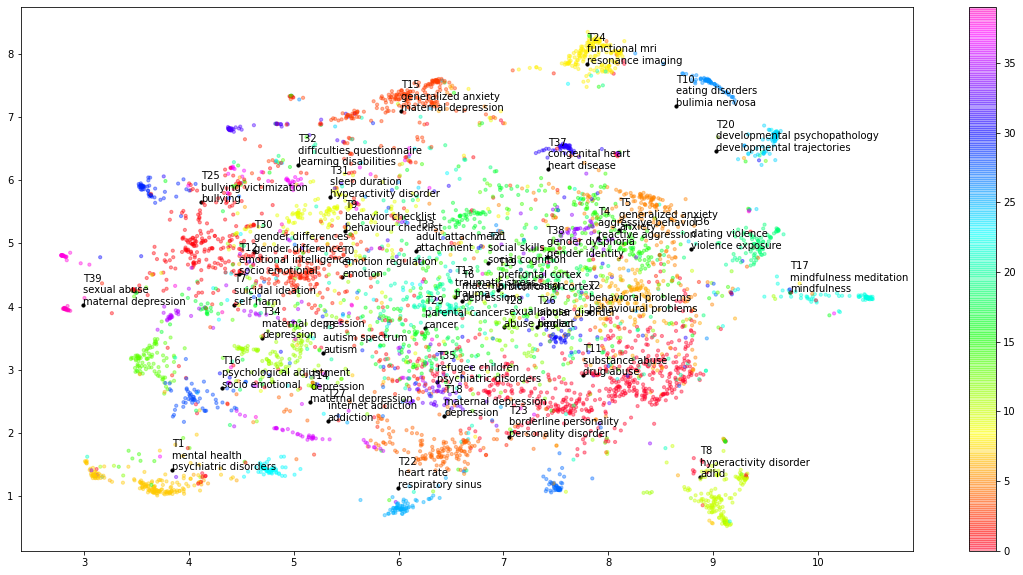

In [ ]:
# Visualize clusters
fig, ax = plt.subplots(figsize=(20, 10))
plt.scatter(topics_labels_keywords_df.x, topics_labels_keywords_df.y, s=10, color = "black")
plt.scatter(result.x, result.y, c=result.labels, s=10, cmap='gist_rainbow', alpha= 0.4)
for i, name in enumerate(topics_labels_keywords_df.names):
    plt.text(topics_labels_keywords_df.x[i],  topics_labels_keywords_df.y[i], name, fontsize = 10)
plt.colorbar()

## ABSTRACTS


In [ ]:
list_abstracts = df_abstracts['abstract'].to_list()

In [ ]:
model_abstracts = Top2Vec(list_abstracts, embedding_model='universal-sentence-encoder', ngram_vocab= True, speed="deep-learn", workers=8)

2022-06-20 13:25:31,824 - top2vec - INFO - Pre-processing documents for training
INFO:top2vec:Pre-processing documents for training
2022-06-20 13:25:49,543 - top2vec - INFO - Downloading universal-sentence-encoder model
INFO:top2vec:Downloading universal-sentence-encoder model
2022-06-20 13:25:56,107 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding
2022-06-20 13:26:03,777 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents
2022-06-20 13:26:22,318 - top2vec - INFO - Finding dense areas of documents
INFO:top2vec:Finding dense areas of documents
2022-06-20 13:26:22,616 - top2vec - INFO - Finding topics
INFO:top2vec:Finding topics


In [ ]:
abstracts_embeddings =  model_abstracts.document_vectors

In [ ]:
N_topics = model_abstracts.get_num_topics()
N_topics

39

In [ ]:
topic_words_abs, word_scores, topic_nums = model_abstracts.get_topics()


In [ ]:
umap_data_ab = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine').fit_transform(abstracts_embeddings)
result_ab = pd.DataFrame(umap_data_ab, columns=['x', 'y'])
result_ab['labels'] = pd.Series(model_abstracts.doc_top)

In [ ]:
result_ab['labels'].nunique()

39

In [ ]:
result.groupby(result_ab['labels']).mean()

In [ ]:
len(list_abstracts_names)

39

In [ ]:
topics_labels_abstracts_df = pd.DataFrame(result_ab.groupby(result_ab['labels']).mean())
list_abstracts_names = [f'{words[0]}\n{words[1]}' for words in topic_words_abs]
list_names= [f"T{i}\n{list_abstracts_names[i]}" for i in result_ab['labels'].unique()]
topics_labels_abstracts_df.insert(2, "names", list_names)

topics_labels_abstracts_df

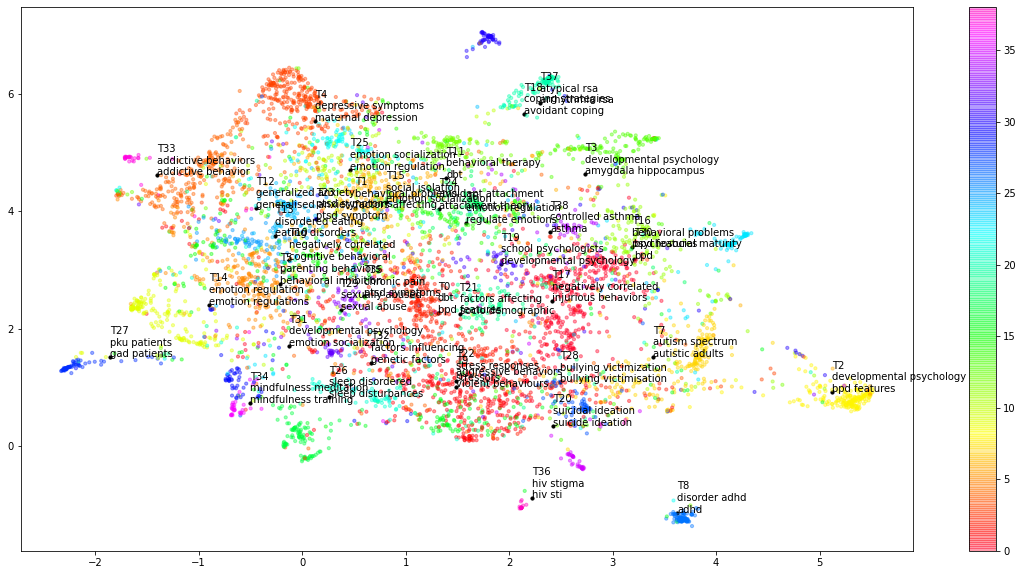

In [ ]:
# Visualize clusters
fig, ax = plt.subplots(figsize=(20, 10))
plt.scatter(topics_labels_abstracts_df.x, topics_labels_abstracts_df.y, s=10, color = "black")
plt.scatter(result_ab.x, result_ab.y, c=result_ab.labels, s=10, cmap='gist_rainbow', alpha= 0.4)
for i, name in enumerate(topics_labels_abstracts_df.names):
    plt.text(topics_labels_abstracts_df.x[i],  topics_labels_abstracts_df.y[i], name, fontsize = 10)
plt.colorbar()

## KEYWORDS COHERENCE AND DIVERSITY

In [ ]:
dataset_keywords = Dataset()
dataset_keywords.load_custom_dataset_from_folder("/content/gdrive/MyDrive/thesis_datasets/emotion_regulation/keywords")

In [ ]:
topics_old = [list(np.char.upper(topic)[:]) for topic in topic_words_key]
all_words = [word for words in dataset_keywords.get_corpus() for word in words]
topics = []
for topic in topics_old:
    words = []
    for word in topic:
        if word in all_words:
            words.append(word)
        else:
            print(f"error: {word}")
            words.append(all_words[0])
    topics.append(words)
output_keywords = {
    "topics": topics,
}

In [ ]:
npmi_keywords = Coherence(texts=dataset_keywords.get_corpus(), topk=10, measure="c_v")
topic_diversity_keywords = TopicDiversity(topk=10)

In [ ]:
npmi_keywords.score(output_keywords)


0.6858917436424857

In [ ]:
topic_diversity_keywords.score(output_keywords)

0.105

## ABSTRACTS COHERENCE AND DIVERSITY

In [ ]:
dataset_abstracts = Dataset()
dataset_abstracts.load_custom_dataset_from_folder("/content/gdrive/MyDrive/thesis_datasets/emotion_regulation/abstracts")

In [ ]:
topic_words_abs, word_scores, topic_nums = model_abstracts.get_topics()


In [ ]:
topics_old = [list(np.char.upper(topic)[:]) for topic in topic_words_abs]
all_words = [word for words in dataset_abstracts.get_corpus() for word in words]
topics = []
for topic in topics_old:
    words = []
    for word in topic:
        if word in all_words:
            words.append(word)
        else:
            print(f"error: {word}")
            words.append(all_words[0])
    topics.append(words)
output_abstracts = {
    "topics": topics,
}

In [ ]:
npmi_abs = Coherence(texts=dataset_abstracts.get_corpus(), topk=10, measure="c_v")
topic_diversity_abs = TopicDiversity(topk=10)

In [ ]:
npmi_abs.score(output_abstracts)

0.8644024900580669

In [ ]:
topic_diversity_abs.score(output_abstracts)

0.07948717948717948

# NETWORKS

In [ ]:
# create df with nodes and edges
def generate_edges(topic2words):
  word2topics = {}
  for key ,values in topic2words.items():
    for value in values:
      if value in word2topics:
        word2topics[value].append(key)
      else:
        word2topics[value] = [key]

  source = []
  target = []
  for topic, words in topic2words.items():
    for word in words:
      for top in word2topics[word]:
        if top != topic:
          source.append(f"{words[0]}\n{words[1]}")
          target_words = topic2words[top]
          target.append(f"{target_words[0]}\n{target_words[1]}")


  df = pd.DataFrame()
  df['source'] = source
  df['target'] = target
  df['weight'] = 1

  return df

In [ ]:
def create_dict_top2word(topic_words):
  topic2words = {}
  for i, words in enumerate(topic_words):
      topic2words[i] = words[:5]
  return topic2words


In [ ]:
def df2network(edges_df):
  network = nx.from_pandas_edgelist(edges_df, source = 'source', target = 'target', edge_attr = 'weight',create_using=nx.MultiGraph())
  return network

## KEYWORDS NETWORK

In [ ]:
keywords_edges = generate_edges(create_dict_top2word(topic_words_key))
keywords_edges.to_csv("Top2Vec_keywords_emotions_network.csv")

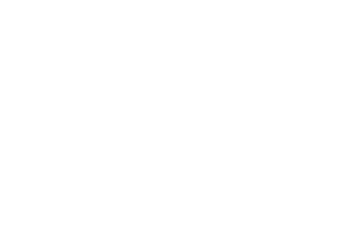

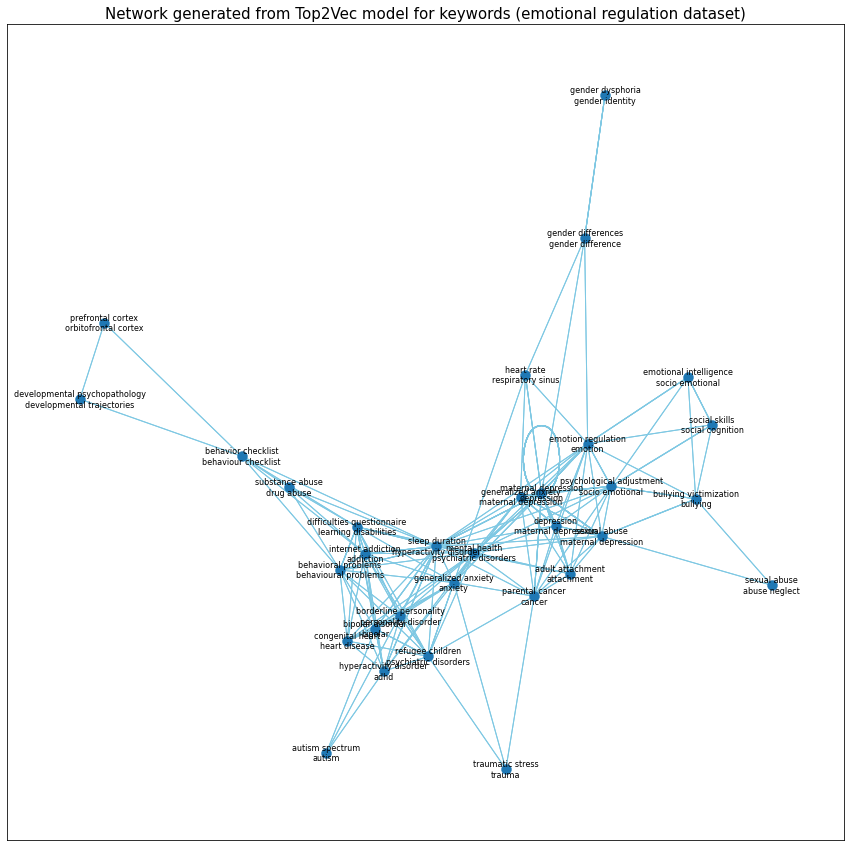

In [ ]:
#create plot 2D

limits = plt.axis("off")
fig, ax = plt.subplots(1, 1, figsize=(15,15))
ax.set_title('Network generated from Top2Vec model for keywords (emotional regulation dataset)', 
             fontdict = {'fontsize': 15})
nx.draw_networkx(df2network(keywords_edges), node_size = 100, ax = ax, 
                 edge_color = '#7EC8E3',  linewidths = 0.4, font_size = 8)
                 

In [ ]:
#create interactive plot network
net = Network(notebook=True)

net.from_nx(df2network(keywords_edges))

net.show("Top2Vec_net_keywords_emotions.html")

## ABSTRACTS NETWORK

In [ ]:
abstracts_edges = generate_edges(create_dict_top2word(topic_words_abs))
abstracts_edges.to_csv("Top2Vec_abstracts_emotions_network_df.csv")

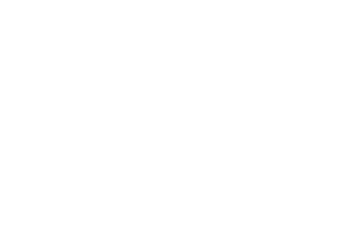

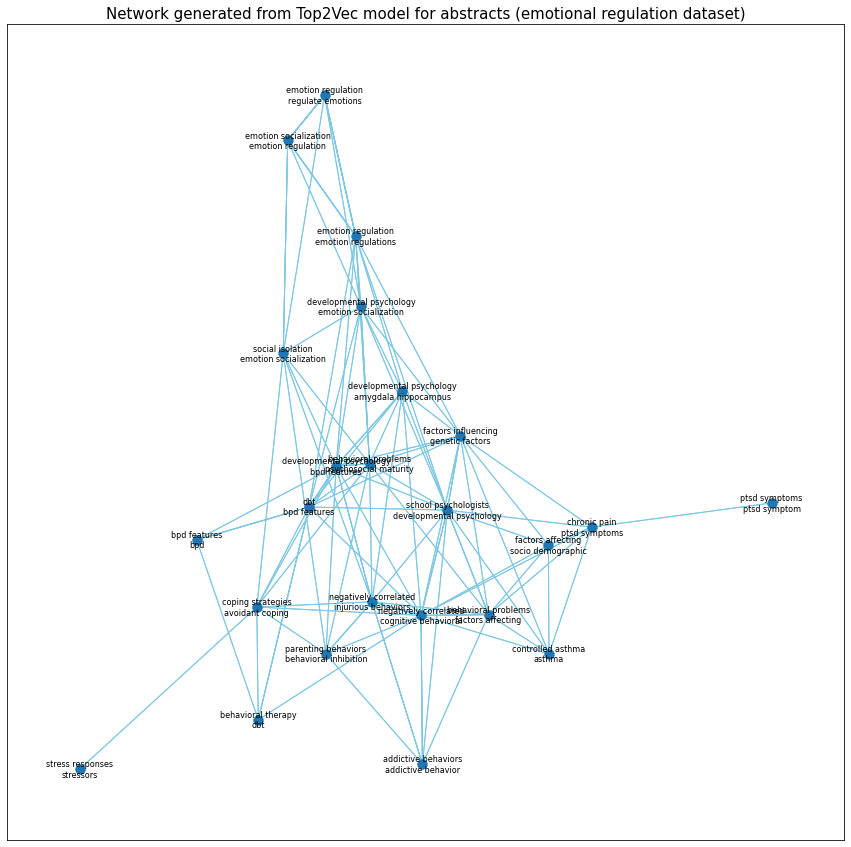

In [ ]:
# create plot 2D

limits = plt.axis("off")
fig, ax = plt.subplots(1, 1, figsize=(15,15))
ax.set_title('Network generated from Top2Vec model for abstracts (emotional regulation dataset)', 
             fontdict = {'fontsize': 15})
nx.draw_networkx(df2network(abstracts_edges), node_size = 100, ax = ax, 
                 edge_color = '#7EC8E3',  linewidths = 0.4, font_size = 8)

In [ ]:
#create interactive plot network
net = Network(notebook=True)

net.from_nx(df2network(abstracts_edges))

net.show("Top2Vec_net_abstracts_emotions_regulation.html")